In [1]:
# Code to plot the AWG response. 
# Pradip Gatkine (24 Feb 2021)

import numpy as np;
import matplotlib.pyplot as plt
from astropy.io import fits
import math
from scipy.optimize import curve_fit
import glob
import os
import sys
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec

import re
plt.rc('font', family='serif')
from matplotlib import rc
import pandas as pd


#rc('font', **{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

# Import File

In [2]:
# Importing the data file here. You can also simply use the name of the file here.
# This assumes that the data file is in the same folder as the code. If not, please add the relative or full path of the file
# This import statement works in Linux. A different library/statement maybe needed for Windows
#print ("Current working dir : S%s" % os.getcwd())
import pprint
File_list = sorted(glob.glob("*.dat"))
for file in range(len(File_list)):
    File_list[file] = os.getcwd() + "\\" + File_list[file]
pprint.pprint(File_list)

['C:\\Users\\engin\\Documents\\GitHub\\2021_SURF_Marcos_Perez\\Res1k_TE_Phase_Err_0.dat']


In [3]:
file_num = 0
chan_num = 13 # This is the number of channels in the AWG. For higher resolution AWGs, this number will be higher.
              # You could also simply find the number of columns in the data and determine the number of channels. 
a = np.arange(0, chan_num+1)
a_string = [str(a_i) for a_i in a] 
df = pd.DataFrame()
df = pd.read_csv(File_list[file_num], sep="\s+", names=a_string)
for ind in a_string[1:]:
    df[ind] = 10*np.log10(df[ind])
df['0'] = 1000*df['0']  # df['0'] is wavelength in micron, multiplying by 1000 to convert to nm.

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1518.225000,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
1,1518.289583,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
2,1518.354167,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
3,1518.418750,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
4,1518.483333,-58.525701,-54.671896,-54.415431,-57.261132,-48.621739,-27.542934,-1.674947,-27.542934,-48.621742,-57.261095,-54.415431,-54.671769,-58.525775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1559.816667,-8.013770,-37.500060,-64.897441,-49.474692,-52.351693,-54.609351,-52.292071,-52.653039,-54.360324,-53.928756,-55.510825,-47.110866,-23.438925
645,1559.881250,-8.827469,-39.368273,-61.938130,-49.195380,-52.603066,-54.766917,-52.193044,-52.958395,-54.826350,-53.349001,-56.716359,-46.816968,-21.587701
646,1559.945833,-9.745225,-41.406588,-60.278128,-49.111147,-52.997867,-54.849464,-52.138185,-53.271204,-55.208465,-52.796803,-57.542710,-46.983646,-19.815234
647,1560.010417,-10.768259,-43.032119,-59.854118,-49.252442,-53.529308,-54.828829,-52.068439,-53.591695,-55.466202,-52.222053,-58.780592,-47.094139,-18.136651


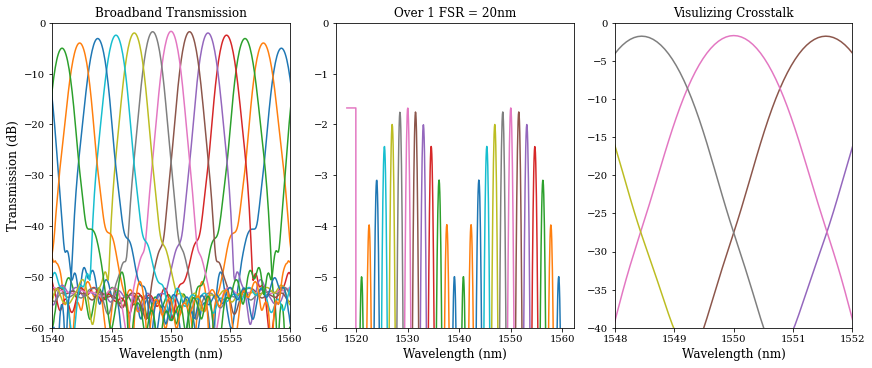

In [5]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))
#plt.plot(range(len(df['0'])), df['0'])
#done defining the Emission_line object!
fig3 = plt.figure(constrained_layout=True, figsize=(12,5))
gs = fig3.add_gridspec(1, 3) #creates grid with one row and 3 columns
f3_ax1 = fig3.add_subplot(gs[0, 0])
f3_ax1.set_title('Broadband Transmission')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('Over 1 FSR = 20nm')
f3_ax3 = fig3.add_subplot(gs[0, 2])
f3_ax3.set_title('Visulizing Crosstalk')
'''
So how do I display a rectangular signal? For a spectral range 
of .1 nanometer, have a constant signal! 
Let's write this very generally so it's easier to adapt for 
more complicated exercises. So for each wavelength range we have
1 dB = 10log_{10}(P/P_0). We want constant source power over a wavelength 
range of 1 angstrom. 
Since we're in the NIR instead of X ray, you don't need to worry about
individual photons as a function of wavelength.
dBm when the reference power is a single milliwatt. dBW is when the 
reference power is a single watt.
'''
#source_signal = [0]*649
stepsize = df.iloc[0,0]-df.iloc[1,0]
df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_ylabel('Transmission (dB)', fontsize=12)
f3_ax1.set_xlim(1518, 1560)
#f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
#plotting!
f3_ax2.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax1.set_xlim(1540, 1560)
#f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
#plotting!
f3_ax3.set_xlabel('Wavelength (nm)', fontsize=12)
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)

File_in = File_list[file_num]
File_out = File_in[:-4]
plt.savefig(File_out + '.pdf')
plt.show()

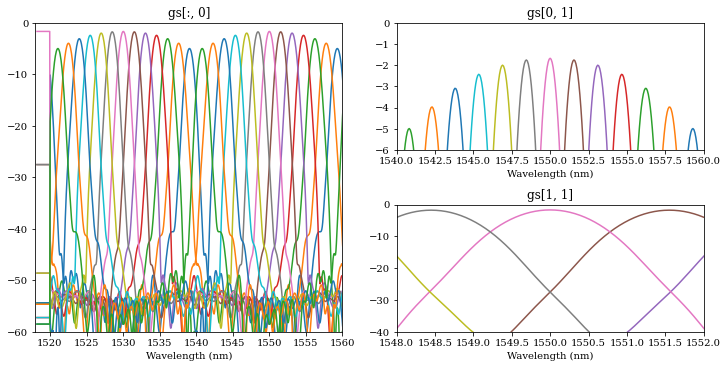

In [6]:
#plt.figure()
#fig, ax = plt.subplots() # plt.subplots(figsize=(15,8))

fig3 = plt.figure(constrained_layout=True, figsize=(10,5))
gs = fig3.add_gridspec(2, 2)
#What does this mean/do??
f3_ax1 = fig3.add_subplot(gs[:, 0])
f3_ax1.set_title('gs[:, 0]')
f3_ax2 = fig3.add_subplot(gs[0, 1])
f3_ax2.set_title('gs[0, 1]')
f3_ax3 = fig3.add_subplot(gs[1, 1])
f3_ax3.set_title('gs[1, 1]')


df.plot(x='0', legend=0, ax = f3_ax1)
#plotting!
f3_ax1.set_xlabel('Wavelength (nm)')
f3_ax1.set_xlim(1518, 1560)
f3_ax1.set_ylim(-60, 0)

df.plot(x='0', legend=0, ax = f3_ax2)
f3_ax2.set_xlabel('Wavelength (nm)')
f3_ax2.set_xlim(1540, 1560)
f3_ax2.set_ylim(-6, 0)

df.plot(x='0', legend=0, ax = f3_ax3)
f3_ax3.set_xlabel('Wavelength (nm)')
f3_ax3.set_xlim(1548, 1552)
f3_ax3.set_ylim(-40, 0)
plt.show()

## ---------- Upto this part is relevant for Marcos for now ---------------------

# Plot 3-dB width

In [7]:
# Reference: 
# Peaks: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
# Peak widths: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.peak_widths.html#scipy.signal.peak_widths

# Finding 3-dB width of the AWG peaks.
from scipy.signal import chirp, find_peaks, peak_widths

def find_3dB_width(lam, op_power_norm_fib, FSR):
    d_lam = lam[1]-lam[0]
    FSR_chunk = np.int(0.8*FSR/d_lam) # Taking 80% of the FSR as the minimum distance between the peaks
    #Consider the 13th channel. A distance of .8*FSR would use peaks from the next spectral order.
    op_power_norm_fib_lin = np.power(10.0,  op_power_norm_fib/10) # converting to linear scale for peak-width measurement

    peaks, _ = find_peaks(op_power_norm_fib_lin, height = .1, distance=FSR_chunk)
    #find_peaks is defind in scipy. You can use it to place the emission lines! Get the array from here
    results_half = peak_widths(op_power_norm_fib_lin, peaks, rel_height=0.5)  # rel_height = 0.5 => FWHM  (half-power beam width)
    #you can define offsets in terms of the FWHM named results_half
    return peaks, lam[peaks], op_power_norm_fib[peaks], d_lam*results_half[0], d_lam  # The zeroth element is width

In [40]:
'''
We need to find the peak wavelength of a channel to use as the center wavelength for 
the first emission line! We will use the find_peaks() function built into scipy and used by Pradip
in the find_3dB_width() function.
Then we will find the appropriate rows by initializing an Emission_line object. Then call the 
function I wrote in it named calculate_power_measured. We will call this function
for each of the 14 channels, then plot each output!

All of the terms have the same definition as the in the Emission_line class. 
channels is just an array of the number of channels (1 indexed).
Remember, the 0th column is still the wavelengths, not the transmission in a channel.
plot_dict is a dictionary where the keys are are the plot colors and the values are
the plot handles
'''
 

def plot_power_vs_channels(center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary, channels, plot_dict, is_dB, ax1):
    emission_line = Emission_line(center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary)
    rows_spanned = emission_line.row_indices_spanned
    #we need to get the transmission from each channel at each wavelength
    integrated_power = np.empty(len(channels))
    for channel in (channels):
        transmission = df.iloc[rows_spanned, channel]
        '''
        Verify this step!
        '''
        transmission = np.array(transmission)
        emission_line.calculate_power_measured(transmission, emission_line.source_power)
        integrated_power[channel-1] = emission_line.integrated_power
    if(is_dB):    
        integrated_power = 10*np.log10(integrated_power)
        #note this will be weird depending on my choice of channels. fix later.
    colors = list(plot_dict.keys())
    handles = list(plot_dict.values())
    for label in list(range(len(plot_dict))):
        ax1.scatter(channels, integrated_power, s=2, color = str(colors[label])) 
        #label = str(handles[label]), color = str(colors[label])
    '''
    The following code exports the plot to the current working directory
    path_title = "\\Simulated_Power_Measured_in_Each_Spectral_Channel\\"
    path_sub_title = "Single_Emission_Line"
    png_path = os.getcwd() + path_title + path_sub_title + ".png"
    pdf_path = os.getcwd() + path_title + path_sub_title + ".pdf"
    plt.savefig(png_path)
    plt.savefig(pdf_path)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_ylim(0,-60)
    '''
    ax1.grid(which='major', color='grey', alpha=0.25)
    xlabel = 'Channel Number'
    #plt.text(1572, -12, 'SMF28 peak = -10.5 dB', fontsize=15, color='red')
    if(is_dB):    
        ylabel = 'Power in dB'
    else:
        ylabel = 'Power (arbitrary units)'
    ax1.set_xlabel(xlabel, fontsize = 8)
    ax1.set_ylabel(ylabel, fontsize = 8)
    ax1.set_ylim(-70, 0)
    ax1.set_title(handles[0], fontsize = 8)
    #legend(loc='upper center', bbox_to_anchor=(.5, -.15))
    #note to self - find appropriate y limits
'''
Now we need to get the peaks!
The rest of this codeblock is just a test using the first channel.  
The next codeblock will include a for loop that progressses through 
all of the odd numbered channels
'''
lam = np.array(df['0'])
FSR = 20
op_power_norm_fib = np.array(df['1'])
peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
center_nanometer = peaks[1][0]
width_nanometer = .1 #1 angstrom
height = 1.0
shape = "rectangular"
symmetrical = True
left_boundary = 0
right_boundary = 0
channels = np.array(list(range(1,14)))
#Now we will make a dictionary to set the colors and labels for everything in the plot
labels = 1
plot_handles, plot_colors = [""]*labels, [""]*labels
plot_handles[0] =  str(width_nanometer) + " nanometer emission line centered at "
plot_handles[0] =  str(plot_handles[0]) +  str(np.around(center_nanometer, 4)) + " nanometers"
plot_colors[0] = 'blue'
plot_dict = {}
for i in range(len(plot_colors)):
    plot_dict[plot_colors[i]] = plot_handles[i]
    
#There are 13 channels but range will only go up to 1 before the second argument!
#plot_power_vs_channels(center_nanometer, width_nanometer, height, shape, symmetrical, left_boundary, right_boundary, channels, plot_dict, True)
#keep a set of plotting templates, formats and commands in place to copy and paste when needed
#We're in the initial steps of plotting, so keep the plotting commands floating rather than in a function
#Worry about additional plots once everything is set up

In [41]:
'''
The class calculates what rows are spanned by an emission line
given its shape, width, and height!

I don't assume the center, or boundaries of the emission line fall on the 
exact wavelengths listed in the first column of the dataframe.

The class Emission_line defines the relevant indices in the dataframe given 
the center-nanometer and width (or alternatively the left_boundary and right_boundary).
If its symmetrical, the input for the left_boundary and right_boundary will be 
disregarded.

So the attributes of the class are: 
self.center_index, self.center_nanometer, self.width_nanometer, self.height, self.shape, 
self.symmetrical  self.center_index, self.smallest_nanometer, self.largest_nanometer, 
self.smallest_index, self.largest_index, self.width_indices, self.row_indices_spanned, 
and self.source_power
It's recommended that  self.row_indices_spanned be used to find the relevant rows in the array

'''
class Emission_line:
   
     #now to find the closest row to the desired center_nanometer
    def __init__(self, center_nanometer, width_nanometer, height, shape, symmetrical, 
                    left_boundary, right_boundary):
        #center_index is index of the center row of the emission line based on its wavelength
        #Will be calculated later
        self.center_index = 0
        self.center_nanometer = center_nanometer
        self.width_nanometer = width_nanometer 
        self.height = height 
        self.shape = shape 
        self.symmetrical = symmetrical
        if(not symmetrical and (left_boundary and right_boundary)):
            self.left_boundary = left_boundary
            self.right_boundary = right_boundary
        #Find the what row best corresponds to the wavelength of the center of the emissin line
        for index in list(range(df.shape[0])):
            if (df.iloc[index,0] == center_nanometer or df.iloc[index,0] > center_nanometer):
                '''
                if there is no wavelength exactly equal to the center we choose the 
                smallest index greater than the desired center. The same will be done for the 
                left boundary (smallest_nanometer) of the emission line. For the right boundary 
                (largest_nanometer) of the emission line, we will instead choose the largest 
                wavelength in the dataframe smaller than the right boundary. 
                '''
                center_index = index
                break
        #we will express everything in arbitary power units
        width_indices  = 1
        smallest_index = 0
        largest_index = df.shape[0]-1
        if(symmetrical):
            self.smallest_nanometer = center_nanometer - (.5*width_nanometer)
            self.largest_nanometer = center_nanometer + (.5*width_nanometer)
        else:
            self.smallest_nanometer = left_boundary
            self.largest_nanometer = right_boundary
        left_range = list(range(0, center_index)) 
        left_range.reverse()
        #left_range is the range within which we'll search for the row with the smallest wavelength
        for index in left_range:
            if (df.iloc[index,0] == self.smallest_nanometer):
                smallest_index = index
                break
            elif (df.iloc[index,0] < self.smallest_nanometer):
                smallest_index = index+1
                break
        for index in list(range(center_index, df.shape[0])):
             if (df.iloc[index,0] == self.largest_nanometer):
                largest_index = index
                break
             elif (df.iloc[index,0] > self.largest_nanometer):
                largest_index = index-1
                break
        if (largest_index < smallest_index or largest_index == smallest_index):
            smallest_index, largest_index = largest_index, smallest_index
            width_indices = 1
            '''
            This can happen for < .1 nm emission lines that are exactly one of the ones in the row.
            '''
        else :
            width_indices = largest_index-smallest_index

        self.center_index = center_index
        #smallest_index is the index of the highest row of the emission line based on its wavelength
        self.smallest_index = smallest_index
        #largest_index is the index of the highest row of the emission line based on its wavelength
        self.largest_index = largest_index
        self.width_indices = width_indices
        #now we'll use these indices to define the array
        #Source_power is an array of the source signal's power at each wavelength. 
        source_power = np.empty(self.width_indices)
        if (self.shape == "Rectangular" or shape == "rectangular"):
            source_power = np.array([self.height]*self.width_indices)
        self.source_power = source_power
        #self.row_indices_spanned is a 1 dimensional array
        self.row_indices_spanned = np.array(list(range(smallest_index, largest_index+1))) 
        #It's recommended that  self.row_indices_spanned be used to find the relevant rows in the array
        self.power_measured = np.empty(len(self.source_power))
        '''
        now let's plot just power vs channel. So we have the transmission in dB, 
        let's convert that to a power in arbitrary power units!
        The function power_measured only calculates everything by wavelength. 
        Integrating by channel is a different step and should be done separately for each channel.
        '''

    def calculate_power_measured(self, transmission, source_power):
        '''
        Wavelength is an index, not the wavelength in nanometers.
        Each element in the source_power array is at a a different wavelength, 
        hence the name wavelength
        '''
        for wavelength in range(len(source_power)): 
            self.power_measured[wavelength] = np.power(10.0,(transmission[wavelength]/10))*source_power[wavelength]
            #based on our definition of transmission
        self.integrated_power = self.power_measured.sum()
        
test = Emission_line(1540, 1, 10, "Rectangular", True, 0, 0)

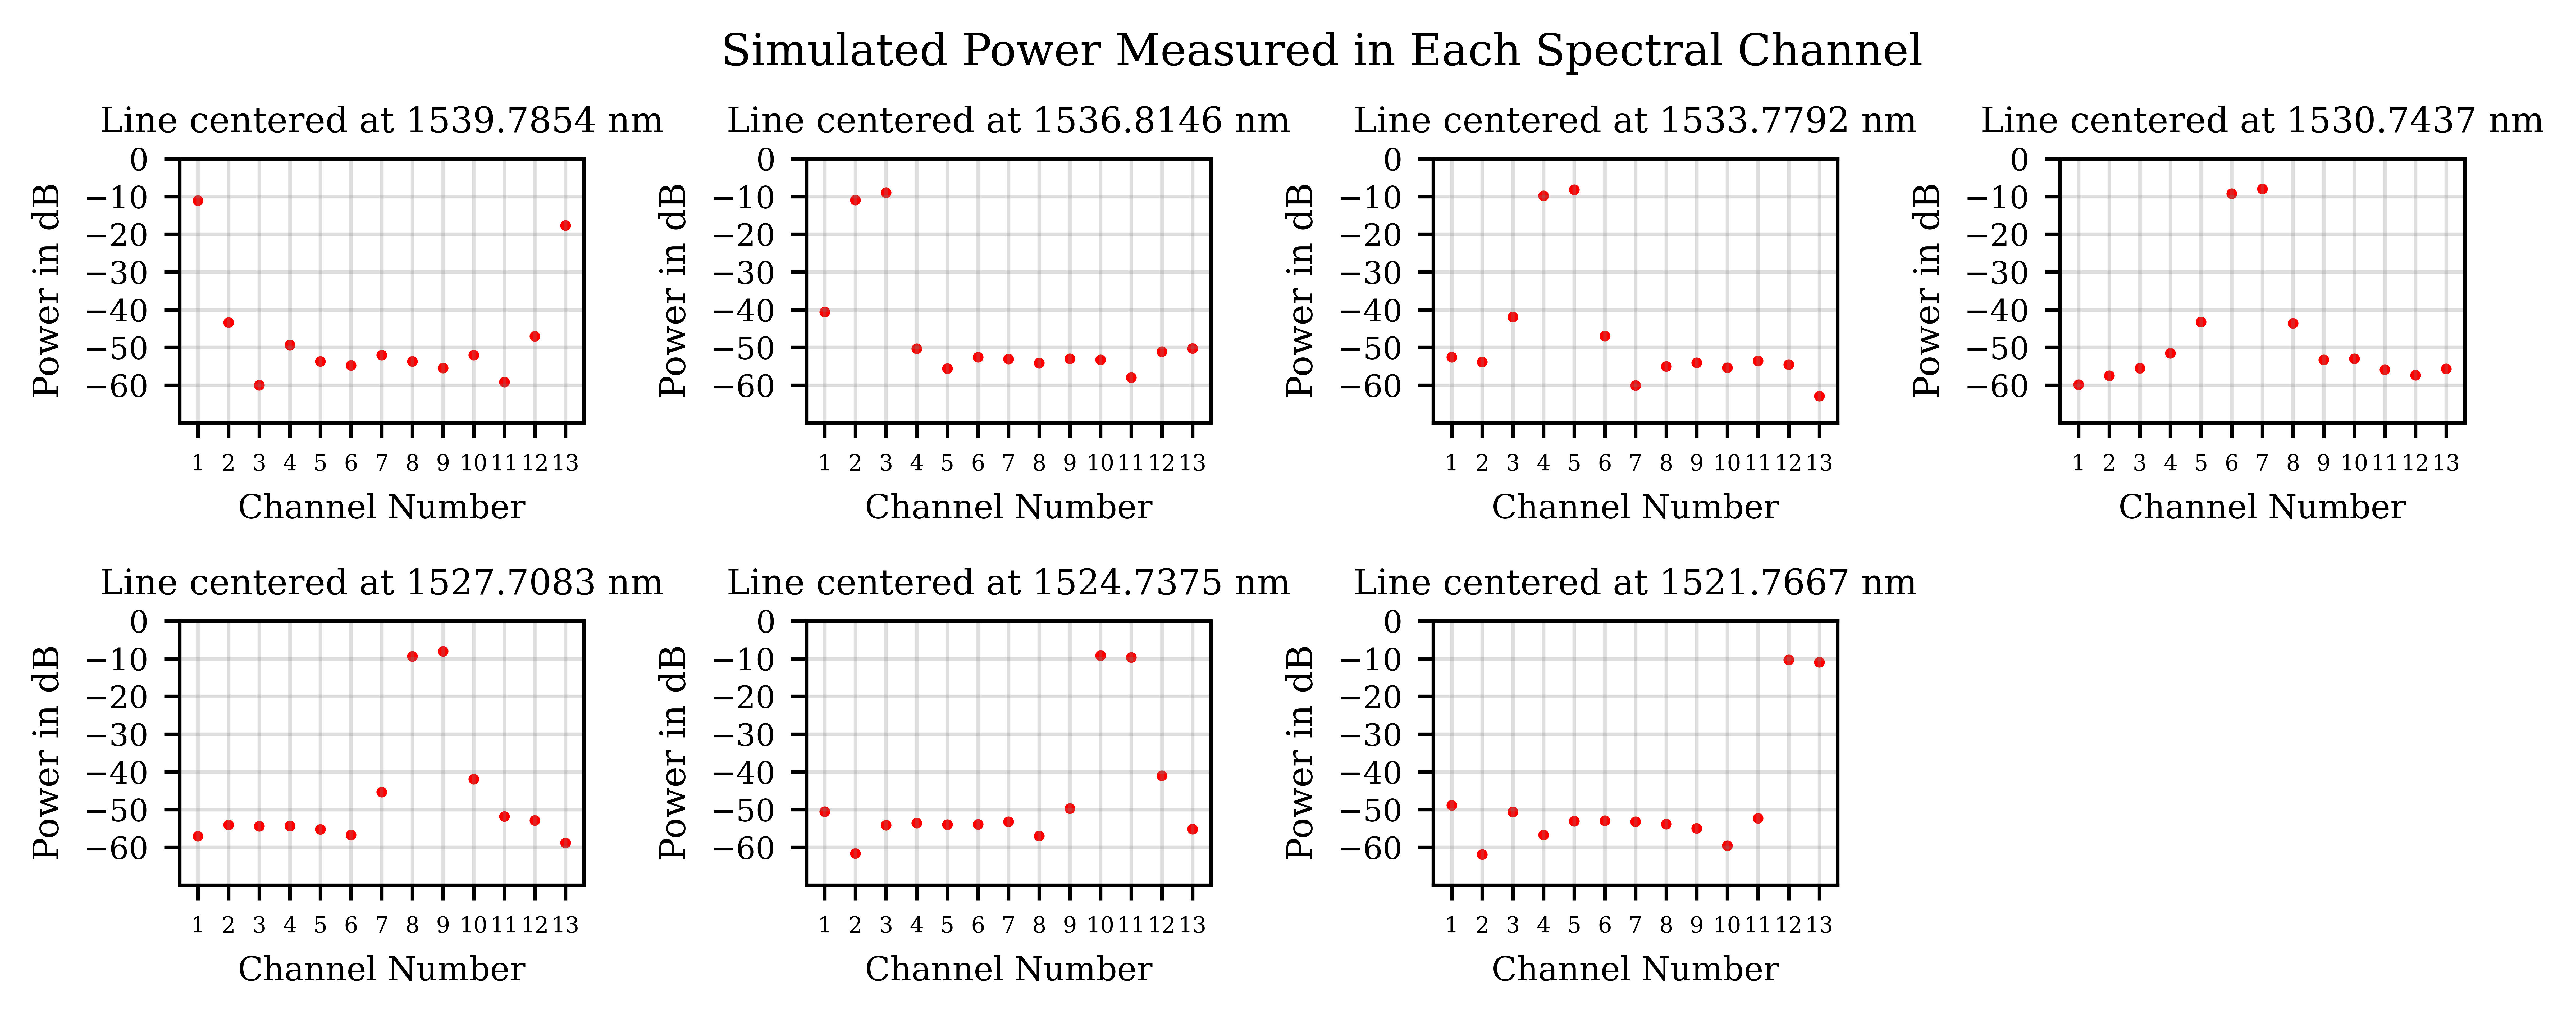

In [50]:
'''
let's make the same plot for emission lines centered at the peak of different 
channels! We will use emission lines centered at the peak of channels 1, 3, 5, 7, and 9.
'''

#fig.text(0.5, 0.04, 'Channel Number', ha='center', fontsize = 'small')
#fig.text(0.04, 0.5, 'Power in dB', va='center', rotation='vertical', fontsize = 'small')
lam = np.array(df['0'])
FSR = 20
offset = .7 #shifting the emission line to the right of the peak by this many nanometers

plt.figure(dpi=1200)
gs = gridspec.GridSpec(4, 4)
#This is so that we can have 7 plots each take up 2 rows 
plt.subplots_adjust(wspace = .55, hspace = .75)
plt.subplots_adjust(top=0.9, left = -.3, bottom = -.4)
plt.suptitle('Simulated Power Measured in Each Spectral Channel', x=.3, y = 1, fontsize=10)
for peak_channel in np.array((1, 3, 5, 7, 9, 11, 13)):
    plot_num = int(.5*(peak_channel-1))
    plot_indices = np.array((int(plot_num/4), plot_num%4))
    '''
    This two element array iterates through the subplot based on which channel we're choosing
    the peak wavelength from. 
    '''
    ax1 = plt.subplot(gs[plot_indices[0], plot_indices[1]])
    plt.setp(ax1, xticks=np.array((range(1,14))), yticks = np.array((range(-60,10,10))))
    ax1.tick_params(axis='x', which='major', labelsize= 5)
    ax1.tick_params(axis='y', which='major', labelsize= 7)
    op_power_norm_fib = np.array(df[str(peak_channel)])
    peaks = find_3dB_width(lam, op_power_norm_fib, FSR)
    center_nanometer = peaks[1][0]+offset
    width_nanometer = .1 #1 angstrom
    height = 1
    shape = "rectangular"
    symmetrical = True
    left_boundary = 0
    right_boundary = 0
    channels = np.array(list(range(1,14)))
    #Now we will make a dictionary to set the colors and labels for everything in the plot
    labels = 1
    plot_handles, plot_colors = [""]*labels, [""]*labels
    plot_handles[0] =  "Line centered at " + str(np.around(center_nanometer, 4)) + " nm"
    plot_colors[0] = 'red'
    plot_dict = {}
    for i in range(len(plot_colors)):
        plot_dict[plot_colors[i]] = plot_handles[i]
    #There are 13 channels but range will only go up to 1 before the second argument!
    plot_power_vs_channels(center_nanometer, width_nanometer, height, shape, symmetrical, 
                        left_boundary, right_boundary, channels, plot_dict, True, ax1=ax1)
'''
caption = "Figure 1: The simulated power measured by the detector after being dispersed by "
caption = caption + "the Arrayed Waveguide Grating (AWG)\n" + "when observing a rectangular"
caption = caption + " emission line with a full width of .1" + " nanometers (nm)."
caption = caption + " Each emission line is centered at " 
if(offset == 0):
    caption = caption + "\n"
else:
    caption = caption + "a\n" + "wavelength "+ str(offset) + " nm longer than " 
caption = caption + "the peak of an odd numbered channel" 
caption = caption + " (channels 1, 3, 5, 7, 9, 11, and 13, respectively)."
plt.text(x = -42, y = -145, s= caption, fontsize = 9)
'''
plt.show()

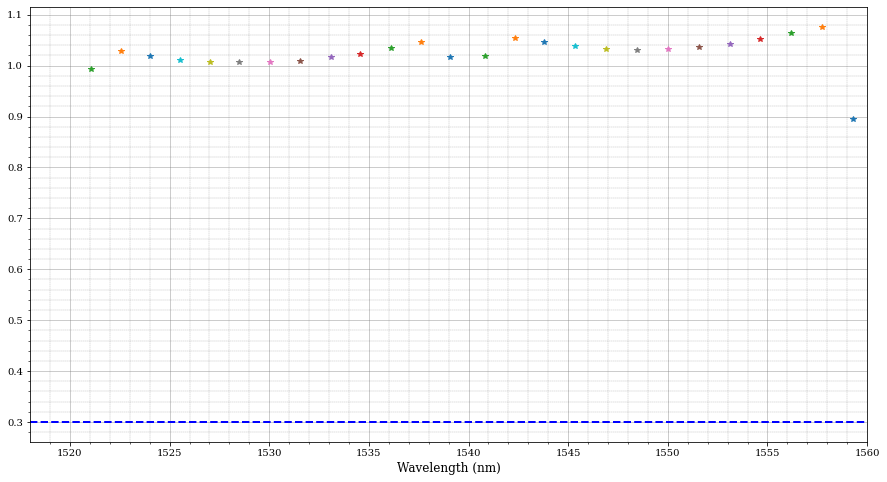

In [31]:
fig, ax = plt.subplots(figsize=(15,8))

for i in range(1,chan_num+1):
    lam = np.array(df['0'])
    op_power_norm_fib = np.array(df[str(i)])
    FSR = 20 # nm
    peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
    #plt.plot(lam, op_power_norm_fib)
    #plt.plot(peak_lam, peak_power, 'b*')
    plt.plot(peak_lam, peak_width, '*')
    

    
ax.minorticks_on()
ax.tick_params(axis='y', which='both')
#ax.grid(which='both')
plt.axhline(y=0.3, linestyle='dashed', color = 'b', linewidth = 2)

#ax = plt.gca()
ax.tick_params(axis='y', which='minor')
ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
ax.grid(which='major', color='grey', alpha=0.5)
ax.set_xlabel('Wavelength (nm)', fontsize=12)

plt.xlim(1518, 1560)  
#plt.ylim(0, 0.75)
#this plot doesn't quite look right. Ask Pradip about it.
#It is fine. This was also used for a specotrgraph with higher spectral resolution
plt.show()
#one point for each channel in each spectral order.

# Plot Spectral Dropout as a function of Resolving power

In [12]:
def get_spectral_dropout(df, probe_channels, FSR, chan_num):
    peak_lam_array = []
    spec_dropout_array = []
    peak_power_array = []
    
    a = np.arange(1, chan_num+1)
    a_string = [str(a_i) for a_i in a] 
    df2 = np.power(10.0, df[a_string]/10.0)
    spectral_sum = np.array(10*np.log10(df2.sum(axis=1)))
    
    for i in probe_channels: #range(1,chan_num+1):  # No need to do this for all the channels, just do it for the central on and edge one
        lam = np.array(df['0'])
        
        op_power_norm_fib = np.array(df[str(i-1)])
        peak_ind_left, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i+1)])
        peak_ind_right, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        op_power_norm_fib = np.array(df[str(i)])
        peak_ind, peak_lam, peak_power, peak_width, d_lam = find_3dB_width(lam, op_power_norm_fib, FSR)
        
        
        peak_power = np.max(peak_power)
        peak_ind = np.max(peak_ind)
        peak_ind_left = np.max(peak_ind_left)
        peak_ind_right = np.max(peak_ind_right)
        
        left_ind = np.min([peak_ind_left, peak_ind, peak_ind_right])
        ind = peak_ind
        right_ind = np.max([peak_ind_left, peak_ind, peak_ind_right])
        
        droupout_left = spectral_sum[peak_ind] - np.min(spectral_sum[left_ind:ind]) 
        droupout_right = spectral_sum[peak_ind] - np.min(spectral_sum[ind:right_ind])
        dropout =  0.5*(droupout_left + droupout_right)
        
        
        peak_lam_array.append(np.max(peak_lam)) # Taking max to ensure only one peak_lam is sent for one channel
        spec_dropout_array.append(dropout)
        peak_power_array.append(peak_power)
    
    return np.array(peak_lam_array), np.array(spec_dropout_array), np.array(peak_power_array)
    


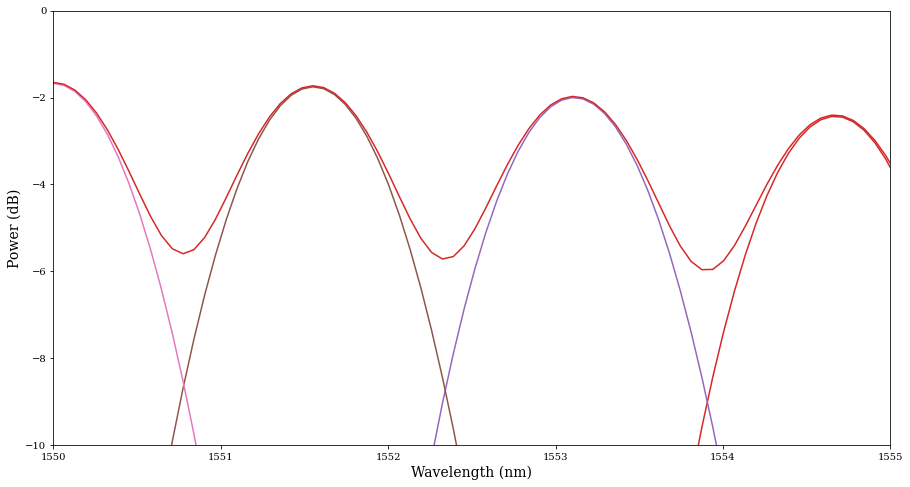

In [13]:
a = np.arange(1, chan_num+1)
a_string = [str(a_i) for a_i in a] 

df2 = np.power(10.0, df[a_string]/10.0)
spectral_sum = 10*np.log10(df2.sum(axis=1))


fig, ax = plt.subplots(figsize=(15,8))
df.plot(x='0', legend=0, ax = ax)
ax.plot(df['0'], spectral_sum)

ax.set_xlabel('Wavelength (nm)', fontsize=14)
ax.set_ylabel('Power (dB)', fontsize=14)
ax.set_xlim(1550, 1555)
ax.set_ylim(-10, 0)

plt.show()